# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

def load_data(pickle_file):

	with open(pickle_file, 'rb') as f:
		save = pickle.load(f)
		X_train = save['train_data']
		y_train = save['train_labels']
		X_tests = save['test_data']
		y_tests = save['test_labels']
		del save  # hint to help gc free up memory
		print('Training set', X_train.shape, y_train.shape)
		print('Testing  set', X_tests.shape, y_tests.shape)

	# split training data into training and validation sets
	nsample = y_train.shape[0]
	ntrain = round(0.9*nsample)

	X_input = X_train[:ntrain]
	X_valid = X_train[ntrain:]

	print('train data shape', X_input.shape)
	print('valid data shape', X_valid.shape)
	print('tests data shape', X_tests.shape)

	y_input = y_train[:ntrain]
	y_valid = y_train[ntrain:]

	print('train label shape', y_input.shape)
	print('valid label shape', y_valid.shape)
	print('tests label shape', y_tests.shape)

	return X_input, y_input, X_valid, y_valid, X_tests, y_tests

pickle_file = 'synthetic.pickle'
X_input, y_input, X_valid, y_valid, X_tests, y_tests = load_data(pickle_file)
image       = [X_input.shape[1], X_input.shape[2], X_input.shape[3]]
print ('image size',image)
ndigit      = y_input.shape[1]  #number of digits in that sample
image_size = image[0]

Training set (73257, 32, 32, 1) (73257, 4)
Testing  set (26032, 32, 32, 1) (26032, 4)
train data shape (65931, 32, 32, 1)
valid data shape (7326, 32, 32, 1)
tests data shape (26032, 32, 32, 1)
train label shape (65931, 4)
valid label shape (7326, 4)
tests label shape (26032, 4)
image size [32, 32, 1]


	1923		92		23		32		2	


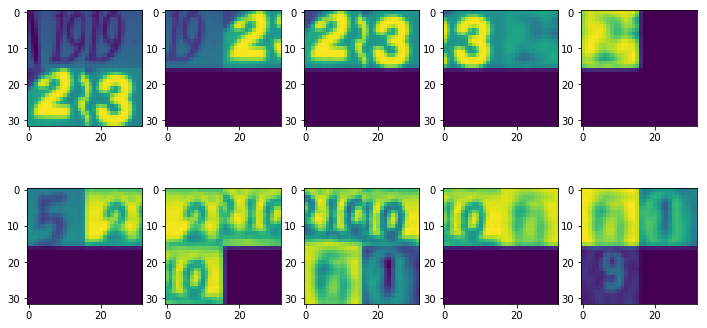

	52		210		1061		06		619	


In [9]:
fig = plt.figure(figsize=(12, 6), dpi=72)
x=''
for i in range(5):
    x= x+'\t'
    for j in y_input[i]:
        if j == 10:
            break
        x = x + str(j)
    x=x+'\t'
print(x)
for i in range(5):
    plt.subplot(2,5,i+1)
    img=X_input[i].reshape(image_size,image_size)
    plt.imshow(img)
    plt.subplot(2,5,i+6)
    img=X_tests[i].reshape(image_size,image_size)
    plt.imshow(img)
plt.show()
x=''
for i in range(5):
    x= x+'\t'
    for j in y_tests[i]:
        if j == 0:
            break
        x = x + str(j)
    x=x+'\t'
print(x)

In [10]:
def accuracy(y, labels):
	return (100.0 * np.sum(np.argmax(y, 2).T == labels) / y.shape[1] / y.shape[0])
def conv2d(x, W, conv_stride, padopt):
	return tf.nn.conv2d(x, W, strides=[1, conv_stride, conv_stride, 1], padding=padopt)

def max_pool(x, pool_size, pool_stride, padopt):
	return tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_stride, pool_stride, 1], padding=padopt)

# Create Variables Function
def weights_conv(shape, name):
    return tf.get_variable(shape=shape, name=name,
        initializer=tf.contrib.layers.xavier_initializer_conv2d())

def weights_fc(shape, name):
    return tf.get_variable(shape=shape, name=name,
        initializer=tf.contrib.layers.xavier_initializer())

def biases_var(shape, name):
    return tf.Variable(tf.constant(0.1, shape=shape), name=name)

In [23]:
def model (X, weights, biases, nconv, conv_params, dropout=False):
	#initialize relu_logits as the input dataset
	[patch_size, conv_stride, pool_size, pool_stride, padopt] = conv_params
	nlayer = len(weights.keys())
	hidden = X
	# build convolution layers
	for layer in range(nconv):
		hidden = tf.nn.relu(conv2d(hidden, weights[layer], conv_stride, padopt) + biases[layer])
		hidden = max_pool(hidden, pool_size, pool_stride, padopt)
		if (dropout):
			hidden = tf.nn.dropout(hidden, .8)

	shape  = hidden.get_shape().as_list()
	cur_logits = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

	for layer in range(nconv, nlayer):
		logits = tf.matmul(cur_logits, weights[layer]) + biases[layer]
		# Transform logits computed from layer 1 using relu function to compute logits for layer2
		if layer < nlayer-1:
			cur_logits = tf.nn.relu(logits)
		# Dropout on hidden layers only
			if dropout:
				cur_logits = tf.nn.dropout(cur_logits, 0.8)

	return logits

# Create Function for Image Size: Pooling
# 3 Convolutions
# 2 Max Pooling
# final_image_size = output_size_pool(image_size, patch_size, conv_stride, pool_size, pool_stride, nlayer

def output_size_pool(input_size, conv_filter_size, conv_stride, pool_filter_size, pool_stride, nlayer, padding):

    pad = 1.0 if padding == 'SAME' else 0.0

    output = input_size
    for layer in range(nlayer):
	    # After convolution
	    output = (((output - conv_filter_size + 2 * pad) / conv_stride) + 1.00)
	    # After pool
	    output = (((output - pool_filter_size + 2 * pad) / pool_stride) + 1.00)

    return int(output)

def pack(y):
	nitems = len(y.keys())
	if nitems > 5:
		print ("too much to pack")
		y_pack = None
	elif nitems == 5:
		y_pack = tf.stack([y[0],y[1], y[2], y[3], y[4]])
	elif nitems == 4:
		y_pack = tf.stack([y[0],y[1], y[2], y[3]])
	elif nitems == 3:
		y_pack = tf.stack([y[0],y[1], y[2]])
	elif nitems == 2:
		y_pack = tf.stack([y[0],y[1]])
	elif nitems == 1:
		y_pack = y[0]
	else:
		print("nothing to pack")
		y_pack = None

	return y_pack
#Create a single hidden layer neural network using RELU and 1024 nodes
def n_layer_cnn (X_train, y_train, X_valid, y_valid, X_test, y_test, image, num_labels, ndigit, depth, num_hidden,
				conv_params, batch_size=128, num_samples=0, num_steps = 1001, print_steps=100, dropout=False):
	if num_samples ==0:
		num_samples = X_train.shape[0]

	# reshape X_train, X_valid and X_test
	graph = tf.Graph()
	#build nodes array and append it with the number of classes which is final number of nodes

	[patch_size, conv_stride, pool_size, pool_stride, padopt] = conv_params
	image_size = image[0]

	with graph.as_default():

		# Input data. For the training data, we use a placeholder that will be fed
		# at run time with a training minibatch.
		tf_X_train = tf.placeholder(tf.float32, shape=(batch_size, image[0], image[1], image[2]))
		tf_y_train = tf.placeholder(tf.int32, shape=(batch_size, ndigit))
		tf_X_valid = tf.constant(X_valid)
		tf_X_test  = tf.constant(X_test)

		# save weights and biases in a dictionary for each layer
		weights={}
		biases ={}
		logits ={}
		# build weights and biases for each layer for each of the possible 5 digits
		# first dimesion of the weights will be the number of features in the training dataset which is the image size
		loss = 0
		regularizers = 0
		nconv = len(depth)
		nfc   = len(num_hidden)
		nlayer = nconv + nfc + 1

		#build convolution dimensions
		conv_dim = [image[2]] + depth + [num_hidden[0]]
		print ("convolution dimensions", conv_dim)

		# build FC layers dimensions
		final_image_size = output_size_pool(image_size, patch_size, conv_stride, 
                                            pool_size, pool_stride, len(depth), padopt)
		hidden_dim = [final_image_size*final_image_size*depth[-1]] + num_hidden + [num_labels]
		print ("hidden dimensions", hidden_dim)


		print ('final image size', final_image_size)
		for digit in range(ndigit):
			weights[digit] = {}
			biases[digit]  = {}

			# buld weights and biases for convolution layers first
			for layer in range(nconv):
				shape = [patch_size, patch_size, conv_dim[layer], conv_dim[layer+1]]
				weights[digit][layer] = weights_conv(shape,'w'+str(digit)+str(layer))
				biases[digit][layer]  = biases_var([depth[layer]],'b'+str(digit)+str(layer))
				w_l2_loss = tf.nn.l2_loss(weights[digit][layer])
				regularizers = regularizers + w_l2_loss

			# build weights and biases for fully connected layers next
			for layer in range (nconv,nlayer):
				i = layer - nconv # index to hidden layer
				shape = [hidden_dim[i], hidden_dim[i+1]]
				weights[digit][layer] = weights_fc(shape,'w'+str(digit)+str(layer))
				biases[digit][layer]  = biases_var([hidden_dim[i+1]], 'b'+str(digit)+str(layer))
				w_l2_loss = tf.nn.l2_loss(weights[digit][layer])
				regularizers = regularizers + w_l2_loss

			logits[digit] = model (tf_X_train, weights[digit], biases[digit], nconv, conv_params, dropout)
			loss += tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_y_train[:,digit], logits=logits[digit]))

		# Loss function with L2 Regularization with beta
		beta = 0.0001
		loss = tf.reduce_mean(loss + beta * regularizers)

		# Optimize using Gradient Descent
		global_step = tf.Variable(0)  # count the number of steps taken.
		init_learning_rate = 0.05
		learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, decay_steps=100000, decay_rate=0.95, staircase=True)
		#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
		optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

		# Compute prediction for training samples 
		y_pred={}
		for digit in range(ndigit):
			y_pred[digit] = tf.nn.softmax(logits[digit])

		y_train_pred = pack(y_pred)

		# Transform validation samples using the same transformation used above for training samples
		for digit in range(ndigit):
			valid_logits = model (tf_X_valid, weights[digit], biases[digit], nconv, conv_params, dropout)
			y_pred[digit] = tf.nn.softmax(valid_logits)

		y_valid_pred = pack(y_pred)

		# Transform test samples using the same transformation used above for training samples
		for digit in range(ndigit):
			test_logits = model (tf_X_test, weights[digit], biases[digit], nconv, conv_params, dropout)
			y_pred[digit] = tf.nn.softmax(test_logits)

		y_test_pred = pack(y_pred)


	with tf.Session(graph=graph) as session:
		# This is a one-time operation which ensures the parameters get initialized as
		# we described in the graph: random weights for the matrix, zeros for the
		# biases. 
		tf.global_variables_initializer().run()
		print ('\nstep#       Loss     Training Accuracy Validation Accuracy')

		y_temp       = np.zeros([batch_size, ndigit, num_labels], dtype=np.int32)
		y_valid_temp = np.zeros([y_valid.shape[0], y_valid.shape[1], num_labels], dtype=np.int32)
		y_test_temp  = np.zeros([y_test.shape[0], y_test.shape[1], num_labels], dtype=np.int32)

		for step in range(num_steps):
			offset = (step * batch_size) % (num_samples - batch_size)
			# Generate a minibatch from the training dataset for Stocastic Gradient Descent
			batch_X = X_train[offset:(offset + batch_size), :]
			batch_y = y_train[offset:(offset + batch_size), :]
			# Prepare a dictionary telling the session where to feed the minibatch.
			# The key of the dictionary is the placeholder node of the graph to be fed,
			# and the value is the numpy array to feed to it.
			feed_dict = {tf_X_train : batch_X, tf_y_train : batch_y}
			_, l, y_pred = session.run([optimizer, loss, y_train_pred], feed_dict=feed_dict)

			# Run the computations. We tell .run() that we want to run the optimizer,
			# and get the loss value and the training predictions returned as numpy arrays.
			if (step % print_steps == 0):
				y_valid_eval = y_valid_pred.eval()

				print('{0:5d} {1:10.2f} {2:15.2f} {3:15.2f}'.format(step, l, accuracy(y_pred, batch_y), 
				accuracy(y_valid_eval, y_valid)))
				# Calling .eval() on valid_prediction is basically like calling run()
		y_test_eval = y_test_pred.eval()

		print('Test accuracy: {:.1f}'.format(accuracy(y_test_eval, y_test)))
	return y_test_eval, y_valid_eval

In [24]:
batch_size  = 64
num_steps   = 5001
print_steps = 500
dropout     = True
num_sample  = 0 # try with full dataset; otherwise specify the subset
patch_size  = 5
conv_stride = 1
pool_size   = 2
pool_stride = 2
padopt      = 'SAME'
conv_params = [patch_size, conv_stride, pool_size, pool_stride, padopt]
depth       = [  8, 16, 32]
num_hidden  = [1024, 256, 32]
num_labels  = 11
num_samples = 0
y_test_pred, y_valid_pred = n_layer_cnn (X_input, y_input, X_valid, y_valid, X_tests, y_tests, 
										image, num_labels, ndigit, depth, num_hidden, conv_params, 
										batch_size, num_samples, num_steps, print_steps, dropout)

convolution dimensions [1, 8, 16, 32, 1024]
hidden dimensions [512, 1024, 256, 32, 11]
final image size 4

step#       Loss     Training Accuracy Validation Accuracy
    0      10.51            3.91           40.34
  500       6.14           50.78           49.05
 1000       5.23           56.25           49.16
 1500       5.47           55.47           51.89
 2000       5.33           55.47           53.33
 2500       5.64           50.78           56.38
 3000       5.38           55.08           57.99
 3500       5.11           60.55           60.46
 4000       4.32           63.67           61.76
 4500       4.12           65.62           62.37
 5000       4.15           66.41           62.89
Test accuracy: 63.5


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 


As shown in the code cells above, I used a synthetic set of the individual digit SVHN dataset provides to train and validate following model:
1. A 7 layer convolutional neural network using TensorFlow, which yielded accuracy of 63% after 5000 steps.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_



**Answer:**

** TensorFlow CNN Model **

1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
3. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
4. Next a fully connected layer with 128 neurons and rectifier activation function.
5. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

** Keras CNN Model **

1. Convolutional layer with 32 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 16 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
8. Fully connected layer with 50 neurons and rectifier activation.
9. Output layer.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**
For all three models i.e. CNN model with Keras/Theano, NN and CNN model with TensorFlow, notMNIST dataset was used, which was already preprocessed and pickled. However, it still needed to be reformatted to feed to dictionary during runtime(See reformatting function for notMNIST data set). The labels had be one-HOT encoded as well. This data was already normalized. 

I used 80% of the training data for training the model and used remaining 20% for the validation purposes. 


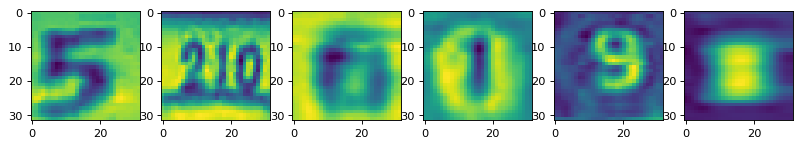

Predicted:5		210		6		1		4		1		


In [54]:
fig = plt.figure(figsize=(12, 6), dpi=82)
for i in range(6):
    plt.subplot(1,6,i+1)
    img=X_tests[i].reshape(image_size,image_size)
    plt.imshow(img)
plt.show()
#get predicted labels for these images
y=np.argmax(y_test_pred, axis=2).T
x='Predicted:'
for i in range(6):
    for j in y[i]:
        if j == 10:
            break
        x = x + str(j)
    x=x+'\t\t'
print(x)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [26]:
pickle_file = 'SVHN.pickle'
X_input, y_input, X_valid, y_valid, X_tests, y_tests = load_data(pickle_file)
image       = [X_input.shape[1], X_input.shape[2], X_input.shape[3]]
print ('image size',image)
ndigit      = y_input.shape[1]  #number of digits in that sample
image_size = image[0]
y_test_pred, y_valid_pred = n_layer_cnn (X_input, y_input, X_valid, y_valid, X_tests, y_tests, 
										image, num_labels, ndigit, depth, num_hidden, conv_params, 
										batch_size, num_samples, num_steps, print_steps, dropout)

Training set (33401, 32, 32, 1) (33401, 5)
Testing  set (13068, 32, 32, 1) (13068, 5)
train data shape (30061, 32, 32, 1)
valid data shape (3340, 32, 32, 1)
tests data shape (13068, 32, 32, 1)
train label shape (30061, 5)
valid label shape (3340, 5)
tests label shape (13068, 5)
image size [32, 32, 1]
convolution dimensions [1, 8, 16, 32, 1024]
hidden dimensions [512, 1024, 256, 32, 11]
final image size 4

step#       Loss     Training Accuracy Validation Accuracy
    0      12.22           18.12           58.38
  500       5.87           62.19           62.98
 1000       4.30           72.50           69.37
 1500       3.82           76.88           76.09
 2000       3.51           82.19           79.54
 2500       4.07           76.88           81.87
 3000       2.52           85.00           82.97
 3500       2.32           89.06           84.35
 4000       2.54           85.00           84.51
 4500       2.65           84.38           85.19
 5000       2.83           82.81          

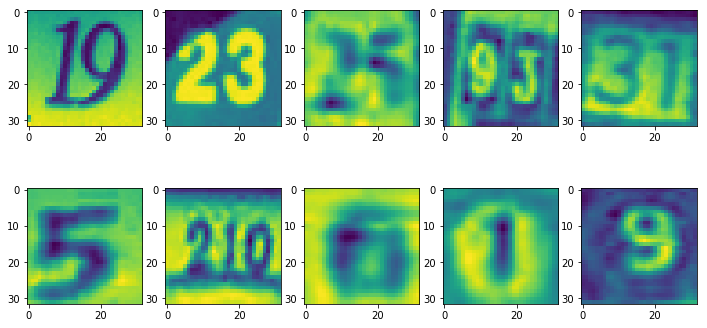

In [30]:
fig = plt.figure(figsize=(12, 6), dpi=72)
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_input[i].reshape(image_size,image_size))
    plt.subplot(2,5,i+6)
    plt.imshow(X_tests[i].reshape(image_size,image_size))
plt.show()

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

I created load_digits_dataset() function to load either the MNIST or the SVHN datasets. The MNIST data was kept in the Theano style format while the SVHN was kept in TensorFlow style format.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**
The NN model with tensor flow performed quite poorly. The introduction of additional layers made the model very sensitive as the gradient descent diverged resulting in NaN for loss. This could be helped by reducing the batch size and learning rate. However ther resulting accuracy was quite bad (in 20%). 

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**
The CNN model using Keras performed quite well under the circumstances and with just 5 epochs reach accuracy of over 80%. The publication at Standford also confirms similar findings as they could also manage no more than 85% accuracy ever after 50 epochs.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [87]:
### Your code implementation goes here.
### Feel free to use as many code cells as needed.
seed = 7
np.random.seed(seed)
#using  Street View House Numbers (SVHN) data set (Not MNIST data)
X_train, y_train, X_test, y_test, input_shape, num_classes = load_digits_dataset (mnist_data=False)
# build the model
model = larger_model(input_shape, num_classes)
# Fit the model using 80% of training data and use remaining 20% for validation
n = round(.9*X_train.shape[0])
model.fit(X_train[:n], y_train[:n], validation_data=(X_train[n:], y_train[n:]), nb_epoch=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test  accuracy: %.2f%%" % (scores[1]*100))




Real Set      X Shape,       Y_shape
Training (32, 32, 3, 73257) (73257,)
Testing  (32, 32, 3, 26032) (26032,)

Final Data      X Shape,       Y_shape
Training (73257, 32, 32, 3) (73257, 10)
Testing  (26032, 32, 32, 3) (26032, 10)
input shape (32, 32, 3)
Train on 65931 samples, validate on 7326 samples
Epoch 1/10
412s - loss: 1.7769 - acc: 0.2899 - val_loss: 1.2376 - val_acc: 0.5273
Epoch 2/10
386s - loss: 1.1545 - acc: 0.5442 - val_loss: 0.8277 - val_acc: 0.6650
Epoch 3/10
383s - loss: 0.8770 - acc: 0.6430 - val_loss: 0.6557 - val_acc: 0.7210
Epoch 4/10
388s - loss: 0.7860 - acc: 0.6752 - val_loss: 0.5902 - val_acc: 0.7453
Epoch 5/10
385s - loss: 0.7333 - acc: 0.6942 - val_loss: 0.5782 - val_acc: 0.7510
Epoch 6/10
391s - loss: 0.6946 - acc: 0.7059 - val_loss: 0.5512 - val_acc: 0.7568
Epoch 7/10
387s - loss: 0.6701 - acc: 0.7151 - val_loss: 0.5191 - val_acc: 0.7689
Epoch 8/10
385s - loss: 0.6494 - acc: 0.7216 - val_loss: 0.4996 - val_acc: 0.7734
Epoch 9/10
385s - loss: 0.6350 - acc: 

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

In [22]:
import cv2
def get_image(imagefiles):
	nfile = len(imagefiles)
	img = np.zeros((nfile,32,32,3), dtype=np.float32)
	for i in range(nfile):
		img[i,] = cv2.imread(imagefiles[i])
	return img

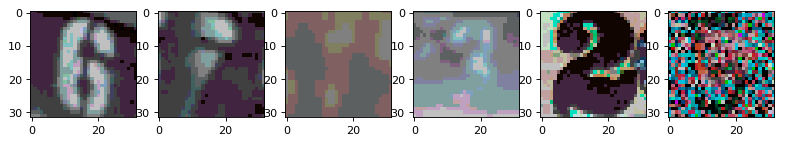

In [63]:
imagefiles =['digit1.bmp', 'digit2.bmp','digit3.bmp','digit4.bmp','digit5.bmp','digit6.bmp']
img = get_image(imagefiles)
fig = plt.figure(figsize=(12, 6), dpi=80)
for i in range(len(imagefiles)):
    plt.subplot(1,6,i+1)
    plt.imshow(img[i])
plt.show()

**Answer:**

I chose these images as they are from around my house and represent various fonts and some are really faded, e.g. third one. The last image is made with flowers in the garden.

In [32]:
y_pred = model.predict(img)
np.argmax(y_pred, 1)

array([6, 7, 7, 3, 2, 5], dtype=int64)

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**
As evident from the answer above, the model was able to predict all new six images correctly.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.